<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/Homework%201%20-%20Multivariate%20Linear%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 : Multivariate Linear Regression

The purpose of this exercise is to create a multivariate linear regression model from the data provided in the "bottle.csv" file. The variables, 'Salnty' & 'STheta', are used as predictors in the model, and 'T_DegC' will be the response variable. 



## Global Variables & Packages

In [0]:
# Generic Packages
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

# Model Packages
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.preprocessing import StandardScaler

#Plotting Packages
%matplotlib inline
import matplotlib
import pylab 
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

#Utility stuff
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive, files
drive.mount('/content/gdrive')

np.random.seed(235)

In [0]:
#INPUT PARAMETERS
HW_NUM=1
INPUT_DATA_FILE='bottle.csv'
NOTEBOOK_NAME='Ambassador {}.ipynb'.format(HW_NUM)

In [0]:
#GLOBAL PARAMETERS
GD_CODE_DIR='/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR='Machine Learning & Predictive Analytics/'
HOMEWORK_DIR='Homework {}'.format(HW_NUM)

#GENERIC PARAMETERS
DATA_DIR='data/'
MODEL_DIR='models/'
LOGS_DIR = 'logs/'

MAIN_PATH=os.path.join(GD_CODE_DIR
                      ,SUBJECT_DIR
                      ,HOMEWORK_DIR)

INPUT_FILE=os.path.join(MAIN_PATH
                       ,DATA_DIR
                       ,INPUT_DATA_FILE)

NOTEBOOK_FILE=os.path.join(MAIN_PATH
                          ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH=os.path.join(MAIN_PATH
                              ,MODEL_DIR)

LOG_PATH=os.path.join(MAIN_PATH
                     ,LOGS_DIR)

## Exploratory Analysis

The data is loaded from the .csv file provided.


In [4]:
#Load Data and take a look
water_data = pd.read_csv(INPUT_FILE)
water_df = pd.DataFrame(water_data)
print(water_df.head())
print('\n Columns from input file: \n {}'.format(water_df.columns))

   Cst_Cnt  Btl_Cnt       Sta_ID                                Depth_ID  \
0        1        1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0000A-3   
1        1        2  054.0 056.0  19-4903CR-HY-060-0930-05400560-0008A-3   
2        1        3  054.0 056.0  19-4903CR-HY-060-0930-05400560-0010A-7   
3        1        4  054.0 056.0  19-4903CR-HY-060-0930-05400560-0019A-3   
4        1        5  054.0 056.0  19-4903CR-HY-060-0930-05400560-0020A-7   

   Depthm  T_degC  Salnty  O2ml_L  STheta  O2Sat         ...           \
0       0   10.50  33.440     NaN  25.649    NaN         ...            
1       8   10.46  33.440     NaN  25.656    NaN         ...            
2      10   10.46  33.437     NaN  25.654    NaN         ...            
3      19   10.45  33.420     NaN  25.643    NaN         ...            
4      20   10.45  33.421     NaN  25.643    NaN         ...            

   R_PHAEO  R_PRES  R_SAMP  DIC1  DIC2  TA1  TA2  pH2  pH1  \
0      NaN       0     NaN   NaN   NaN  Na

The regression will perform better if observations with values of Null or 'NaN' in the variables of interest are removed. Some high level statistics are generated for the data (shown below). 

An intercept column is added to the predictor set. This represents the reponse when no predictors are used in the model.

High Level Statistics of the predictors: 
              Salnty         STheta
count  812174.000000  812174.000000
mean       33.842424      25.819394
std         0.461567       1.167787
min        28.431000      20.934000
25%        33.490000      24.965000
50%        33.869200      25.996000
75%        34.198000      26.646000
max        37.034000     250.784000
High Level Statistics of the response: 
              T_degC
count  812174.000000
mean       10.847904
std         4.221005
min         1.440000
25%         7.750000
50%        10.100000
75%        13.910000
max        31.140000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f408ef989b0>]],
      dtype=object)

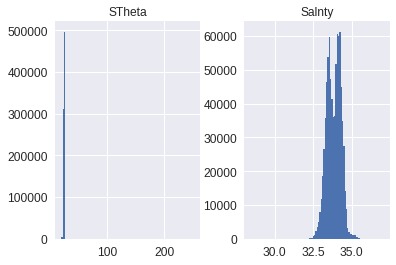

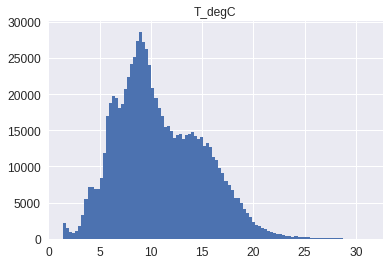

In [5]:
# Remove observations with nulls
water_df_clean = water_df[water_df.Salnty.notnull() 
                          & water_df.STheta.notnull() 
                          & water_df.T_degC.notnull()]

# Variable definitions
predictors = ['Salnty', 'STheta']
response = ['T_degC']

X_df = water_df_clean[predictors]
print('High Level Statistics of the predictors: \n{}'.format(X_df.describe()))
X_df.hist(bins=100)

X_df['Intercept'] = 1

y_df = water_df_clean[response]
print('High Level Statistics of the response: \n{}'.format(y_df.describe()))
y_df.hist(bins=100)



The 'STheta' histogram shows an extreme concentration near 0, but the x scale goes to 200. This could indicate outliers. A cut off will be created at 200 to remove observations with an Shetha value greater than 200.


 Shape of Response DF:   (812174, 1)

 Shape of Predictors DF: (812174, 3)

 Shape of X:   (812168,)

 Shape of y:   (812168, 3)

 Distribution of STheta w/ outliers removed:

AxesSubplot(0.125,0.125;0.775x0.755)


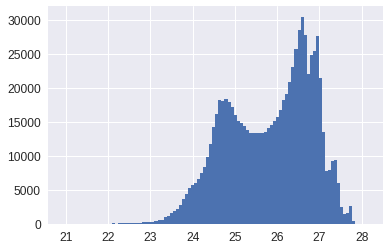

In [6]:
stheta_cut_off = 200

print('\n Shape of Response DF:   {}'.format(y_df.shape))
print('\n Shape of Predictors DF: {}'.format(X_df.shape))

y = y_df[X_df['STheta'].values < stheta_cut_off].values.ravel()
X = X_df[X_df['STheta'].values < stheta_cut_off].values

# Checking shapes is a good habit to get into
print('\n Shape of X:   {}'.format(y.shape))
print('\n Shape of y:   {}'.format(X.shape))

#Histogram of Stheta using logic from above
hist = X_df[X_df['STheta'].values < stheta_cut_off]['STheta'].hist(bins=100)
print('\n Distribution of STheta w/ outliers removed:\n\n{}'.format(hist))

6 observations from the data have been removed using the 'STheta' cut off of 200. The historgram for the STheta variable looks much more representitive of a continuous distribution one can expect from the measurements taken to generate this data. 

I have a sneaky suspicion there was a data input error, as 'STheta' values over 200 correspond to an obervation with an extra 0 added to a more standard value.

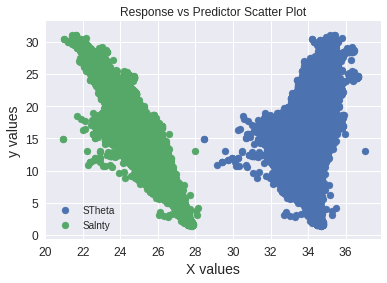

In [7]:
plt.scatter(X[:,0],y,label='STheta')  #specify label for the corresponding curve
plt.scatter(X[:,1],y,label='Salnty')  #-don't worry about it for now.
plt.grid(True)
plt.legend()
plt.title('Response vs Predictor Scatter Plot')
plt.xlabel('X values')
plt.ylabel('y values')
plt.show()


From the plots above, 'Salnty' appears to have a negative relationship and 'STheta' a postive. 

## Sklearn : Linear Regression Model

A linear regression model from the sklearn library is initiated and fit to the **X** and **y** data. The intercept and coefficients are extracted and printed below.

In [12]:
lr = LinearRegression()
lr.fit(X, y)

# Get Coefficients from model
lr_intercept = np.array( [lr.intercept_] )
lr_coeffs = np.array([lr.coef_[:2]])

#Dataframe of coefficients
lr_parameters = pd.DataFrame(np.concatenate((lr_coeffs.T, lr_intercept.reshape(1,1))))
lr_parameters.columns = ['Betas']
lr_parameters.rename(index={0:'Salnty (Beta_1)',1:'STheta (Beta_2)', 2:'Intercept (Beta_0)'}, inplace=True)
print(round(lr_parameters, 4))

                      Betas
Salnty (Beta_1)      3.1084
STheta (Beta_2)     -5.0376
Intercept (Beta_0)  35.7088


The parameters from the regression confirm the relations seen in the scatter plots of the data.

The scoring method for this model is R-Squared  which represents the ratio of *variance explained* by the model to *total variance* of the data to which the model is fit. 

The predict method is used to extract the predicted response using the true **X** values. The difference between this prediction and the actual response is the residual. This is used to calculate the Root Mean Squared Error, which represents the average deviance of the model prediction from the model observation.

VAF is **FINISH**


In [13]:
# R Squared
lr_score = lr.score(X, y)

# Predictions & errors
lr_y_hat = lr.predict(X)
lr_residuals = y - lr_y_hat

#RMSE and VAF
lr_RMSE = math.sqrt(mean_squared_error(y, lr_y_hat))
lr_VAF_score = explained_variance_score(y, lr_y_hat)

print('Linear Regression R-Squared: {}'.format(round(lr_score, 4)))
print('Linear Regression RMSE: {}'.format(round(lr_RMSE,4)))
print('Linear Regression Variance Explained: {}'.format(round(lr_VAF_score, 4)))

Linear Regression R-Squared: 0.9869
Linear Regression RMSE: 0.4829
Linear Regression Variance Explained: 0.9869


The range on this scoring metric is 0 to 1 so the model performed **extremely** well, explaining almost 99% of the variance using only 2 variables. 

##Normal Equation Calculation Model

Next the Beta parameters for the linear regression model will be solved for analytically using the Normal equation show below: 

The solution to the normal equation are the best parameters of a Linear Regression on a **Normal distribution**. The normal distribution is what is being assumed about the data's errors $\epsilon$, with a mean of 0 and a standard deviation of 1.


The solution to this equation gives the best coefficients for a model based on the X and y provided.

In [14]:
#(X.T . X)^-1 . (X.T * y)
NE_params = np.dot(
              #INV:
              np.linalg.inv(
                # X.T * X 
                np.dot(np.transpose(X),X))
            , # X.T * Y
              np.dot(np.transpose(X), y)
                  )

NE_params = pd.DataFrame(NE_params)
NE_params.columns = ['Coefficients']
NE_params.rename(index={0:'Salnty',1:'STheta', 2:'Intercept'}, inplace=True)
print(round(NE_params, 4))

           Coefficients
Salnty           3.1084
STheta          -5.0376
Intercept       35.7088


The model parameters are exactly the same as the parameters from the sklearn model.

The model predictions' are calculated from solutions parameters. The models total residuals or, $SSE$  (Sum of Squares Error) is calculated, along with $SST$ (Sum of Squares Total). SST is the total sum squared difference between the $y_i$ and $\bar{y}$, which is the average for all $y_i$. 

The  $R^2$ value is calculated using the equation :  $R^2 = 1 - \frac{SSE}{SST}$


In [24]:
test = np.array(NE_params)
print(test)
print( NE_params)

[[ 3.10844916]
 [-5.0375517 ]
 [35.70884285]]
           Coefficients
Salnty         3.108449
STheta        -5.037552
Intercept     35.708843


In [32]:
#Predictions , residuals, and SSE
NE_yhat = np.dot(X, np.array(NE_params)).T
#NE_yhat = np.array((np.dot(X, np.array(NE_params)))).T
NE_residuals = np.array(NE_yhat - y).ravel()
NE_SSE = np.sum(np.square(NE_residuals)) 

#Ybar and SST
y_bar = np.repeat(np.average(y), y.size)
NE_SST = np.sum(np.square(np.subtract(y_bar, y)))

#Rsquared from SSE & SST
NE_Rsquared = 1-(NE_SSE/NE_SST)

#RMSE & VAF
NE_RMSE = np.sqrt(np.sum(np.square(NE_yhat-y))/NE_yhat.size)
NE_VAF = 1-np.cov(np.array(np.array(y) - np.array(NE_yhat)).flatten())/np.cov(y)

print('Normal Equation R Squared: {}'.format(round(NE_Rsquared, 4)))
print("Normal Equation RMSE: {}".format(round(NE_RMSE,4)))
print('Normal Equation Variance Explained: {}'.format(round(NE_VAF, 4)))

Normal Equation R Squared: 0.9869
Normal Equation RMSE: 0.4829
Normal Equation Variance Explained: 0.9869


The model using the normal equation solution yields the same solution to the sklearn's linear regression model.

The models residuals are shown below, which do conform the the normality assumption implied by definition of a simple linear regression.

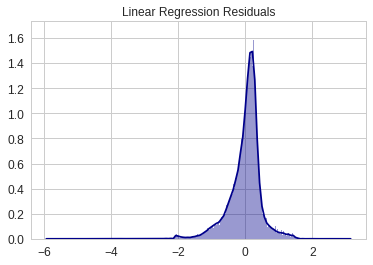

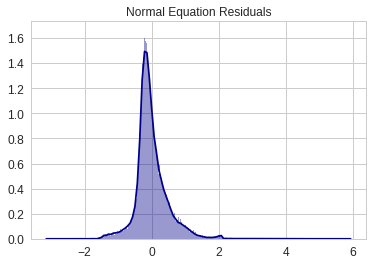

In [36]:
def plot_model_resids(array, header):
    sns.set_style('whitegrid')
    plt.title(header)
    sns.distplot(array
                 , hist=True
                 , kde=True
                 , bins=int(len(array) / 100)
                 , color = 'darkblue'
                )
    plt.show()
    
                 
    
plot_model_resids(lr_residuals, 'Linear Regression Residuals')
plot_model_resids(NE_residuals, 'Normal Equation Residuals')

In [0]:
!jupyter nbconvert --to html '$NOTEBOOK_FILE'

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Code/uchicago/Machine Learning & Predictive Analytics/Homework 1/Homework 1.ipynb to html
[NbConvertApp] Writing 400570 bytes to /content/gdrive/My Drive/Code/uchicago/Machine Learning & Predictive Analytics/Homework 1/Homework 1.html
